In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
## 1. 데이터 불러오기, 공통 전처리
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/newdata2.csv', encoding = 'cp949')
raw_data = raw_data[:-1]

# 컬럼 버리기
raw_data = raw_data.drop(raw_data[['잠수교_유량','대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량','유입량','저수량']], axis = 1)

# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data.drop(input_y.columns, axis = 1)

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,현재수위,공용량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00:00,0.974498,0.094187,0.058462,0.191781,0.010527,0.147596,0.011070,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.974262,0.095096,0.058447,0.199253,0.011332,0.147654,0.011070,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.974066,0.095758,0.057689,0.209215,0.011129,0.147478,0.011070,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.974066,0.095758,0.058462,0.219178,0.010726,0.147478,0.011475,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.974066,0.095758,0.058451,0.232877,0.010726,0.146810,0.011883,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.983929,0.119863,0.046624,0.458281,0.006375,0.106425,0.025719,0.0,0.0,0.0,0.0
2022-07-18 23:20:00,0.983929,0.119863,0.046621,0.488169,0.006213,0.097370,0.026815,0.0,0.0,0.0,0.0
2022-07-18 23:30:00,0.983929,0.119863,0.046620,0.515567,0.008259,0.092994,0.027929,0.0,0.0,0.0,0.0


In [ ]:
## 2. train / test data 생성

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  432 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:48<00:00, 20.79s/it]


In [ ]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(264672, 432, 7)
(264672, 4)
(6912, 432, 7)
(6912, 4)


In [ ]:
def inverse_transform(y_test, yhat):
     y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
     yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
     yhat_inverse = scaler.inverse_transform(yhat_reshaped)
     y_test_inverse = scaler.inverse_transform(y_test_reshaped)
     return yhat_inverse, y_test_inverse

In [ ]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    rmse = np.sqrt(mae_(y_test_inverse,yhat_inverse))
    print('rmse:', rmse)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [ ]:
"""
if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history
"""

"\nif 'model_enc_dec_cnn' in locals(): \n    del model_enc_dec_cnn \nif 'history' in locals():\n    del history\n"

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(w, 7)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
#model_enc_dec_cnn.add(GlobalMaxPooling1D())

model_enc_dec_cnn.add(RepeatVector(1))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))
#model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
#model_enc_dec_cnn.add(TimeDistributed(Dense(4)))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [ ]:
model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 424, 64)           4096      
                                                                 
 conv1d_1 (Conv1D)           (None, 414, 64)           45120     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 207, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 13248)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 13248)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 200)               1

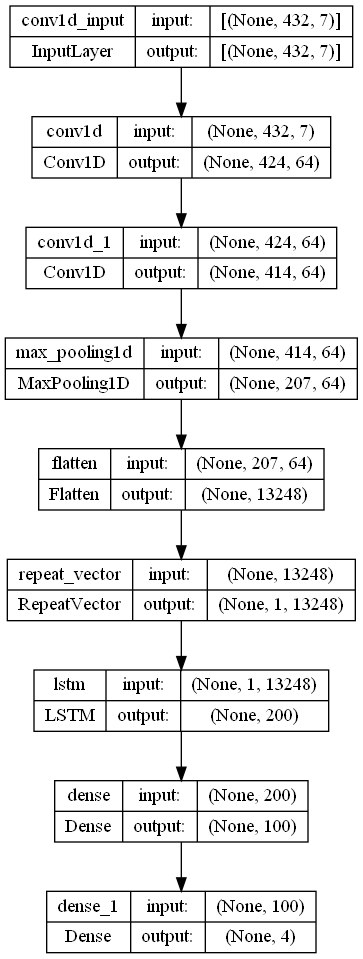

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 50
batch_size = 32
validation = 0.1

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/50
7444/7444 [==============================] - 850s 114ms/step - loss: 17.2275 - accuracy: 0.8777 - val_loss: 9.0102 - val_accuracy: 0.9001 - lr: 0.0100
Epoch 2/50
7444/7444 [==============================] - 798s 107ms/step - loss: 10.4669 - accuracy: 0.8963 - val_loss: 10.0631 - val_accuracy: 0.9055 - lr: 0.0100
Epoch 3/50
7444/7444 [==============================] - 806s 108ms/step - loss: 9.3617 - accuracy: 0.8971 - val_loss: 7.8292 - val_accuracy: 0.9061 - lr: 0.0100
Epoch 4/50
7444/7444 [==============================] - 800s 107ms/step - loss: 9.0770 - accuracy: 0.8979 - val_loss: 8.8115 - val_accuracy: 0.8895 - lr: 0.0100
Epoch 5/50
7444/7444 [==============================] - 801s 108ms/step - loss: 8.7484 - accuracy: 0.8978 - val_loss: 9.5296 - val_accuracy: 0.9089 - lr: 0.0100
Epoch 6/50
7444/7444 [==============================] - 801s 108ms/step - loss: 8.5886 - accuracy: 0.8989 - val_loss: 9.0021 - val_accuracy: 0.9056 - lr: 0.0100
Epoch 7/50
7444/7444 [=========

KeyboardInterrupt: 

## 이건 기본 모델.
he normal같은걸로 바꾼 뒤 비교

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [ ]:
yhat = keras_model_best.predict(xtest, verbose=1)

216/216 [==============================] - 6s 24ms/step


In [ ]:
yhat

array([[285.93484, 277.28012, 276.61975, 272.71573],
       [285.78647, 277.0582 , 276.3302 , 272.2118 ],
       [286.3139 , 276.79843, 275.45538, 269.304  ],
       ...,
       [301.0073 , 296.99423, 300.89838, 311.22757],
       [308.71106, 302.87192, 305.6836 , 312.0971 ],
       [316.94638, 308.6976 , 309.96814, 310.97638]], dtype=float32)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(ytest, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

rmse: 375.5731
mse: tf.Tensor(38550508000.0, shape=(), dtype=float32)
mape: tf.Tensor(1.4563689, shape=(), dtype=float32)


In [ ]:
keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 5s 22ms/step - loss: 5.8366 - accuracy: 0.9051


[5.836603164672852, 0.9050925970077515]

NameError: name 'history' is not defined

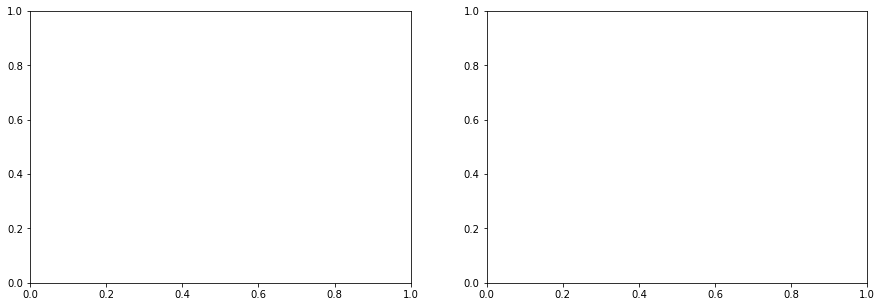

In [ ]:
#학습 과정 표시하기
%matplotlib inline
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

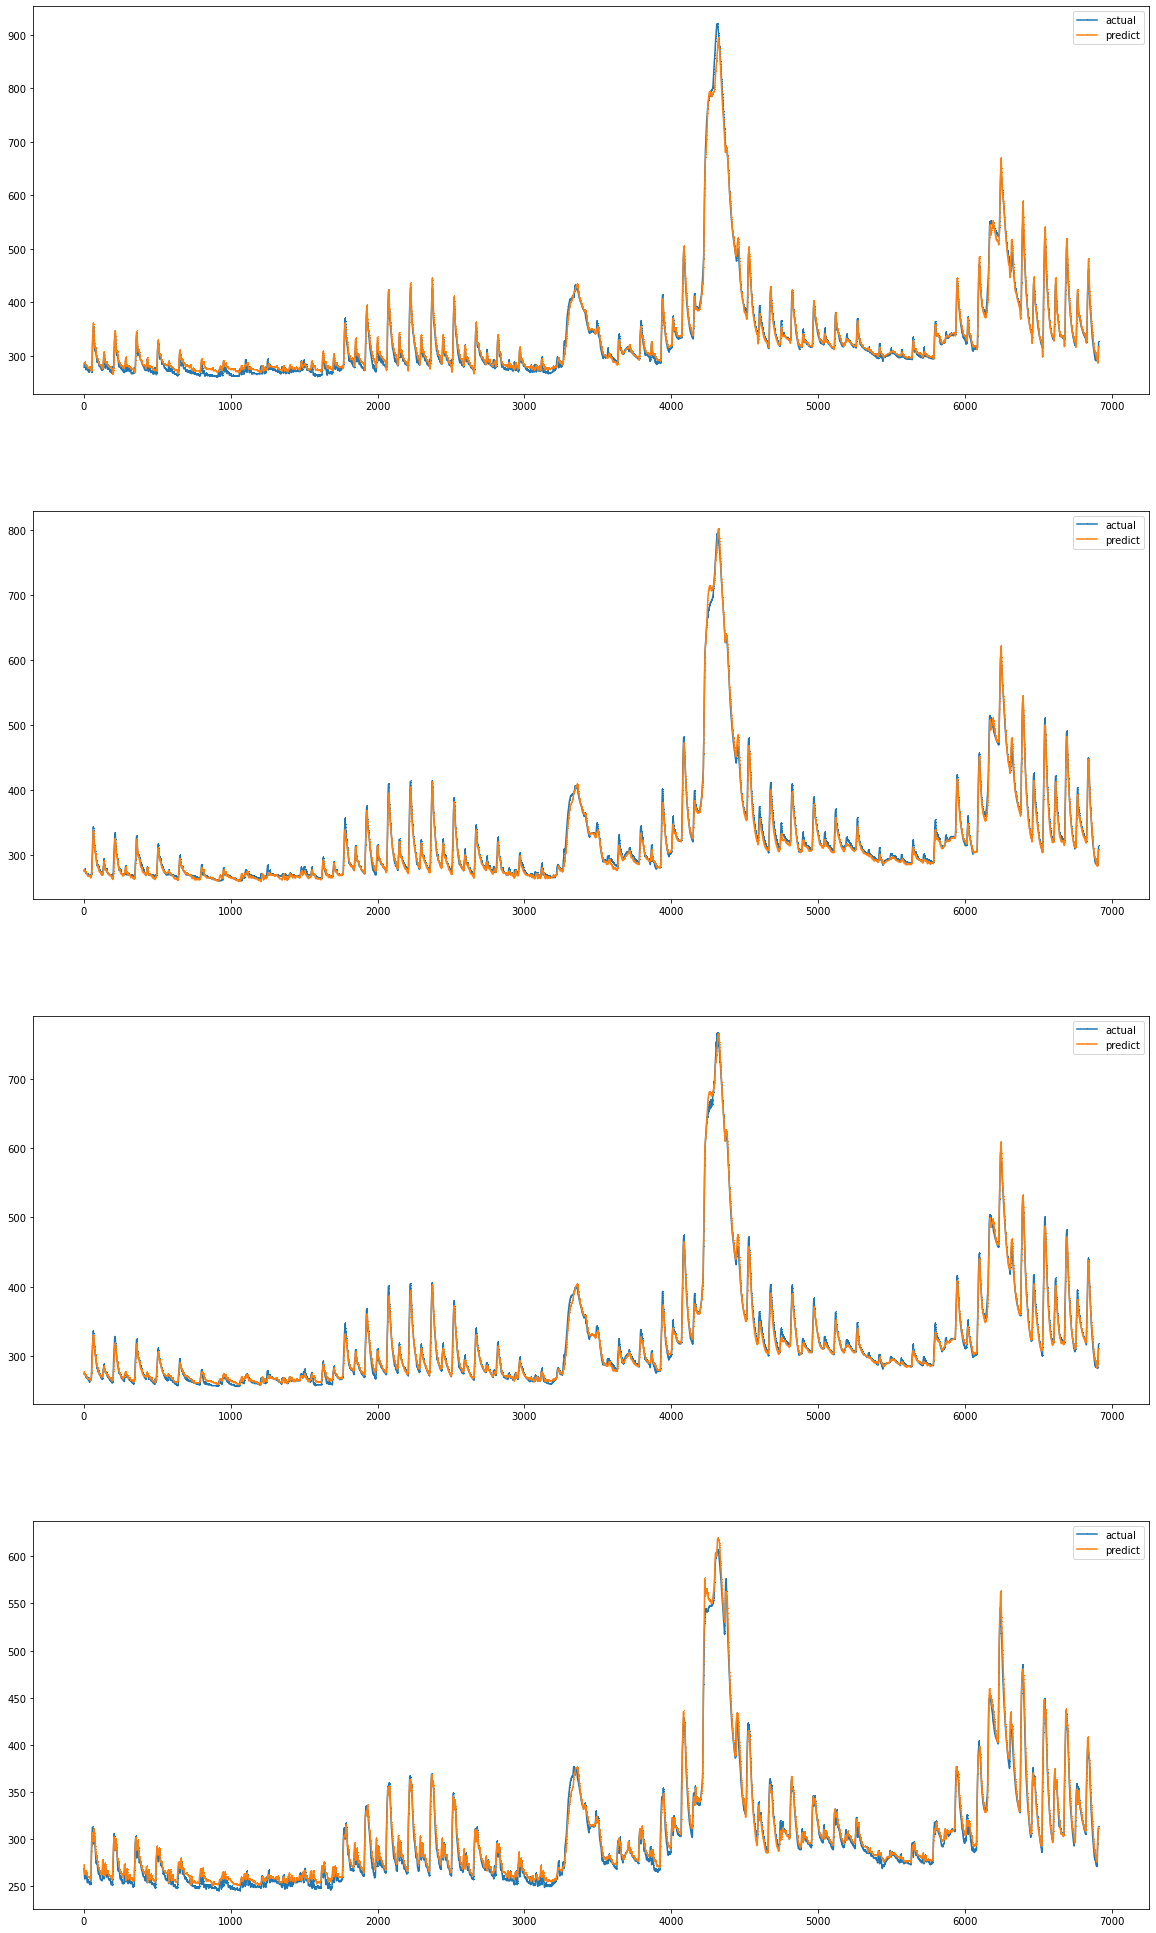

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [ ]:
#점수 채점하기
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(8.417047669982304, shape=(), dtype=float64)
tf.Tensor(6.1868618114201634, shape=(), dtype=float64)
tf.Tensor(5.320484816045954, shape=(), dtype=float64)
tf.Tensor(6.169828045022695, shape=(), dtype=float64)
최종점수:  6.523555585617779


In [ ]:
#제출 파일 생성

sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0823 conv1d lstm.csv", index = False)

In [ ]:
#결과: 12.9208469187